# CST4070 - Applied Data Analytics - Tools, Practical Big Data Handling, Cloud Distribution
## Airbnb dataset using MongoDB
## Submitted by Jaganivas Chandran Kannaiya 

### Workflow Chart
**1. Data Cleaning & Preprocessing (Python)** <br>
   a. Extracting useful columns from listing for the analyses <br>
   b. Handle missing values <br>
   c. Ensure and convert correct data types <br>
   d. Standardize data formats <br>
**2. Import data into MongoDB** <br>
   a. Set up MongoDB in Python (PyMongo) <br>
   b. Insert the data and create data collections and indexes <br>
**3. Data analysis and taking insights** <br>
   a. Neighborhood Profiles <br>
   b. Most Popular Property Types <br>
   c. Listings with Highest Reviews <br>
   d. Average Ratings Per Property Type <br>
   e. Monthly Review Trends

**1. Data Cleaning & Preprocessing (Python)** <br>
1a. Extracting useful columns from listing for the analyses

In [1]:
import pandas as pd

# Define file paths
listings_file = "listings.csv"  # Path to the listings CSV file
reviews_file = "reviews.csv"  # Path to the reviews CSV file

# Define the selected columns for listings
selected_columns = [
    "id", "neighbourhood_cleansed", "latitude", "longitude",
    "property_type", "room_type", "accommodates", "bathrooms_text",
    "bedrooms", "beds", "amenities", "price", "minimum_nights", "maximum_nights",
    "availability_30", "availability_60", "availability_90", "availability_365",
    "number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d",
    "first_review", "last_review", "review_scores_rating", "review_scores_accuracy",
    "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication",
    "review_scores_location", "review_scores_value", "reviews_per_month", "instant_bookable"
]

# Step 1: Load the listings dataset with only the selected columns
listings_df = pd.read_csv(listings_file, usecols=selected_columns)

# Step 2: Load the reviews dataset and filter only reviews matching listing IDs
reviews_df = pd.read_csv(reviews_file)
reviews_filtered = reviews_df[reviews_df["listing_id"].isin(listings_df["id"])]

# Step 3: Save the cleaned datasets
listings_cleaned_file = "listings_new.csv"
reviews_filtered_file = "reviews_new.csv"

listings_df.to_csv(listings_cleaned_file, index=False)
reviews_filtered.to_csv(reviews_filtered_file, index=False)

print("Cleaned datasets saved successfully as:")
print(f"- {listings_cleaned_file}")
print(f"- {reviews_filtered_file}")

Cleaned datasets saved successfully as:
- listings_new.csv
- reviews_new.csv


1b. Handle missing values in Listings & Reviews: <br>
    Dropping rows with critical missing values (like id or price), filling missing numerical values (e.g., beds, availability_30) with 0 or median, filling missing text values (e.g., amenities, bathrooms_text) with "Unknown" and formatting dates correctly.

In [2]:
import pandas as pd

# Define file paths
listings_file = "listings_new.csv"
reviews_file = "reviews_new.csv"

# Load datasets
listings_df = pd.read_csv(listings_file)
reviews_df = pd.read_csv(reviews_file)

### Step 1: Handling Missing Values in Listings Data

# Drop rows where 'id' or 'price' is missing (critical columns)
listings_df.dropna(subset=["id", "price"], inplace=True)

# Fill missing numerical values with 0 (sensible default)
num_cols = ["accommodates", "bedrooms", "beds", "availability_30", "availability_60", 
            "availability_90", "availability_365", "number_of_reviews", 
            "number_of_reviews_ltm", "number_of_reviews_l30d", "reviews_per_month"]

listings_df[num_cols] = listings_df[num_cols].fillna(0)

# Fill missing review scores with the average rating or 0 if all are missing
review_cols = ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
               "review_scores_checkin", "review_scores_communication",
               "review_scores_location", "review_scores_value"]

listings_df[review_cols] = listings_df[review_cols].fillna(listings_df[review_cols].mean())

# Fill missing text fields with "Unknown"
text_cols = ["bathrooms_text", "property_type", "room_type", "amenities", "instant_bookable"]
listings_df[text_cols] = listings_df[text_cols].fillna("Unknown")

# Convert 'price' to numeric (removing currency symbols if present)
listings_df["price"] = listings_df["price"].replace(r"[\$,]", "", regex=True).astype(float)

# Convert 'first_review' and 'last_review' to datetime format
listings_df["first_review"] = pd.to_datetime(listings_df["first_review"], errors='coerce')
listings_df["last_review"] = pd.to_datetime(listings_df["last_review"], errors='coerce')

### Step 2: Handling Missing Values in Reviews Data 

# Drop rows where 'listing_id' is missing (since it's required for linking)
reviews_df.dropna(subset=["listing_id"], inplace=True)

# Fill missing text fields with "No Review"
reviews_df["comments"] = reviews_df["comments"].fillna("No Review")

# Convert 'date' to datetime format
reviews_df["date"] = pd.to_datetime(reviews_df["date"], errors='coerce')

### Step 3: Save Cleaned Datasets
listings_filled_file = "listings_filled.csv"
reviews_filled_file = "reviews_filled.csv"

listings_df.to_csv(listings_filled_file, index=False)
reviews_df.to_csv(reviews_filled_file, index=False)

print("Missing values handled successfully!")
print(f"Filled files saved as:\n- {listings_filled_file}\n- {reviews_filled_file}")

Missing values handled successfully!
Filled files saved as:
- listings_filled.csv
- reviews_filled.csv


1c. Ensure and convert correct data types <br>
Converts price to float (removes currency symbols), converts availability & numerical columns to int, ensures review scores & counts are float or int and formats first_review, last_review, and date columns as datetime.

In [3]:
import pandas as pd

# Define file paths
listings_file = "listings_filled.csv"
reviews_file = "reviews_filled.csv"

# Load datasets
listings_df = pd.read_csv(listings_file)
reviews_df = pd.read_csv(reviews_file)

### Step 1: Convert Data Types in Listings Data

# Convert 'price' to float (removing currency symbols if present)
listings_df["price"] = listings_df["price"].replace(r"[\$,]", "", regex=True).astype(float)

# Convert availability and review count columns to integers
int_columns = ["availability_30", "availability_60", "availability_90", "availability_365",
               "number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d"]

listings_df[int_columns] = listings_df[int_columns].fillna(0).astype(int)

# Convert review scores to float (they may contain NaN values)
review_columns = ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
                  "review_scores_checkin", "review_scores_communication",
                  "review_scores_location", "review_scores_value"]

listings_df[review_columns] = listings_df[review_columns].astype(float)

# Convert 'accommodates', 'bedrooms', 'beds' to integer (fill missing values with 0)
num_cols = ["accommodates", "bedrooms", "beds"]
listings_df[num_cols] = listings_df[num_cols].fillna(0).astype(int)

# Convert 'first_review' and 'last_review' to datetime format
listings_df["first_review"] = pd.to_datetime(listings_df["first_review"], errors='coerce')
listings_df["last_review"] = pd.to_datetime(listings_df["last_review"], errors='coerce')

### Step 2: Convert Data Types in Reviews Data

# Convert 'date' column to datetime
reviews_df["date"] = pd.to_datetime(reviews_df["date"], errors='coerce')

# Ensure 'listing_id' is integer (some may have missing values)
reviews_df["listing_id"] = reviews_df["listing_id"].fillna(0).astype(int)

### Step 3: Save Converted Datasets
listings_converted_file = "listings_converted.csv"
reviews_converted_file = "reviews_converted.csv"

listings_df.to_csv(listings_converted_file, index=False)
reviews_df.to_csv(reviews_converted_file, index=False)

print("Data types converted successfully!")
print(f"Converted files saved as:\n- {listings_converted_file}\n- {reviews_converted_file}")

Data types converted successfully!
Converted files saved as:
- listings_converted.csv
- reviews_converted.csv


Check if all data types are consistent (correct and same) in listings & reviews

In [37]:
import pandas as pd

# Define file paths
listings_file = "listings_converted.csv"
reviews_file = "reviews_converted.csv"

# Load datasets
listings_df = pd.read_csv(listings_file)
reviews_df = pd.read_csv(reviews_file)

### Expected Data Types for Listings ###
expected_listings_dtypes = {
    "id": "int64",
    "neighbourhood_cleansed": "object",
    "latitude": "float64",
    "longitude": "float64",
    "property_type": "object",
    "room_type": "object",
    "accommodates": "int64",
    "bathrooms_text": "object",
    "bedrooms": "int64",
    "beds": "int64",
    "amenities": "object",
    "price": "float64",
    "minimum_nights": "int64",
    "maximum_nights": "int64",
    "availability_30": "int64",
    "availability_60": "int64",
    "availability_90": "int64",
    "availability_365": "int64",
    "number_of_reviews": "int64",
    "number_of_reviews_ltm": "int64",
    "number_of_reviews_l30d": "int64",
    "first_review": "datetime64[ns]",
    "last_review": "datetime64[ns]",
    "review_scores_rating": "float64",
    "review_scores_accuracy": "float64",
    "review_scores_cleanliness": "float64",
    "review_scores_checkin": "float64",
    "review_scores_communication": "float64",
    "review_scores_location": "float64",
    "review_scores_value": "float64",
    "reviews_per_month": "float64",
    "instant_bookable": "object"
}

### Expected Data Types for Reviews
expected_reviews_dtypes = {
    "listing_id": "int64",
    "date": "datetime64[ns]",
    "comments": "object"
}

# Convert date columns before checking dtypes
listings_df["first_review"] = pd.to_datetime(listings_df["first_review"], errors="coerce")
listings_df["last_review"] = pd.to_datetime(listings_df["last_review"], errors="coerce")
reviews_df["date"] = pd.to_datetime(reviews_df["date"], errors="coerce")

# Check data types
listings_dtypes = listings_df.dtypes.astype(str)
reviews_dtypes = reviews_df.dtypes.astype(str)

# Identify mismatches
listings_mismatches = {col: (listings_dtypes[col], expected_listings_dtypes[col])
                       for col in expected_listings_dtypes if listings_dtypes[col] != expected_listings_dtypes[col]}

reviews_mismatches = {col: (reviews_dtypes[col], expected_reviews_dtypes[col])
                      for col in expected_reviews_dtypes if reviews_dtypes[col] != expected_reviews_dtypes[col]}

# Display Results
if not listings_mismatches:
    print("Listings dataset has consistent data types.")
else:
    print("Mismatched data types in Listings dataset:")
    for col, (actual, expected) in listings_mismatches.items():
        print(f"- {col}: Expected {expected}, Found {actual}")

if not reviews_mismatches:
    print("Reviews dataset has consistent data types.")
else:
    print("Mismatched data types in Reviews dataset:")
    for col, (actual, expected) in reviews_mismatches.items():
        print(f"- {col}: Expected {expected}, Found {actual}")

Listings dataset has consistent data types.
Reviews dataset has consistent data types.


1d. Standardize Data Formats: <br>
Converts amenities from a string to a list for structured analysis, trims whitespace and standardizes text fields, ensures instant_bookable is standardized to "Yes" or "No" and lowercases text values where applicable for consistency.

In [5]:
import pandas as pd
import ast  # To safely convert string representations of lists

# Define file paths
listings_file = "listings_converted.csv"
reviews_file = "reviews_converted.csv"

# Load datasets
listings_df = pd.read_csv(listings_file)
reviews_df = pd.read_csv(reviews_file)

### Step 1: Standardize Text Fields in Listings Data

# Convert 'amenities' column from string to list format
def convert_amenities(amenities_str):
    try:
        # Convert string representation of list to actual list
        amenities_list = ast.literal_eval(amenities_str)
        if isinstance(amenities_list, list):
            return [amenity.strip().lower() for amenity in amenities_list]  # Standardize case & remove extra spaces
        else:
            return []
    except (ValueError, SyntaxError):
        return []

listings_df["amenities"] = listings_df["amenities"].apply(convert_amenities)

# Standardize text fields by lowercasing and removing extra spaces
text_columns = ["property_type", "room_type", "bathrooms_text", "neighbourhood_cleansed"]

for col in text_columns:
    listings_df[col] = listings_df[col].astype(str).str.strip().str.lower()

# Ensure 'instant_bookable' is either "Yes" or "No"
listings_df["instant_bookable"] = listings_df["instant_bookable"].apply(lambda x: "Yes" if str(x).strip().lower() in ["yes", "true"] else "No")

### Step 2: Standardize Text Fields in Reviews Data ###

# Standardize review comments by trimming spaces
reviews_df["comments"] = reviews_df["comments"].astype(str).str.strip()

### Step 3: Save Standardized Datasets ###
listings_standardized_file = "listings_standardized.csv"
reviews_standardized_file = "reviews_standardized.csv"

listings_df.to_csv(listings_standardized_file, index=False)
reviews_df.to_csv(reviews_standardized_file, index=False)

print("Text data standardized successfully!")
print(f"Standardized files saved as:\n- {listings_standardized_file}\n- {reviews_standardized_file}")

Text data standardized successfully!
Standardized files saved as:
- listings_standardized.csv
- reviews_standardized.csv


**2. Import data into MongoDB** <br>
a. Set up MongoDB in Python (PyMongo)

In [6]:
pip install pymongo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


2b. Insert the data and create data collections and indexes (to optimize performance):

In [7]:
import pandas as pd
from pymongo import MongoClient

# Define file paths
listings_file = "listings_standardized.csv"
reviews_file = "reviews_standardized.csv"

# Connect to MongoDB (Change 'localhost' to your server IP if remote)
client = MongoClient("mongodb://localhost:27017/")

# Create a new database (if not exists)
db = client["airbnb_data"]

# Create collections
listings_collection = db["listings"]
reviews_collection = db["reviews"]

### Step 1: Import Listings Data into MongoDB
print("Importing Listings Data...")

# Load CSV into Pandas
listings_df = pd.read_csv(listings_file)

# Convert DataFrame to dictionary format for MongoDB insertion
listings_data = listings_df.to_dict(orient="records")

# Insert into MongoDB
listings_collection.insert_many(listings_data)
print(f"Successfully imported {len(listings_data)} listings into MongoDB!")

### Step 2: Import Reviews Data into MongoDB ###
print("Importing Reviews Data...")

# Load CSV into Pandas
reviews_df = pd.read_csv(reviews_file)

# Convert DataFrame to dictionary format
reviews_data = reviews_df.to_dict(orient="records")

# Insert into MongoDB
reviews_collection.insert_many(reviews_data)
print(f"Successfully imported {len(reviews_data)} reviews into MongoDB!")

### Step 3: Verify Import
print("\n Verifying import:")
print(f"- Listings Count: {listings_collection.count_documents({})}")
print(f"- Reviews Count: {reviews_collection.count_documents({})}")

print("\n MongoDB Import Completed Successfully!")

Importing Listings Data...
Successfully imported 63205 listings into MongoDB!
Importing Reviews Data...
Successfully imported 1887519 reviews into MongoDB!

 Verifying import:
- Listings Count: 63205
- Reviews Count: 1887519

 MongoDB Import Completed Successfully!


Choosing Indexes. <br>
1.id - for specific listings. <br>
2️. neighbourhood_cleansed - to speed up queries filtering by neighborhood. <br>
3️. price - to improve sorting performance for price-based analysis. <br>
4️. number_of_reviews & review_scores_rating - to find popular/high-rated listings. <br>
5️. listing_id - to optimizes lookup queries joining reviews with listings. <br>
6️. date - to improve sorting/filtering of reviews over time.

In [8]:
# Indexes for Listings Collection
db.listings.create_index([("id", 1)], unique=True)  # Unique index for fast lookup
db.listings.create_index([("neighbourhood_cleansed", 1)])  # Speeds up filtering by neighborhood
db.listings.create_index([("price", 1)])  # Improves sorting by price
db.listings.create_index([("number_of_reviews", -1)])  # Optimizes ranking by reviews
db.listings.create_index([("review_scores_rating", -1)])  # Filters high-rated listings faster

# Indexes for Reviews Collection
db.reviews.create_index([("listing_id", 1)])  # Speeds up linking reviews to listings
db.reviews.create_index([("date", -1)])  # Optimizes sorting/filtering by review date

print("Indexes created successfully!")

Indexes created successfully!


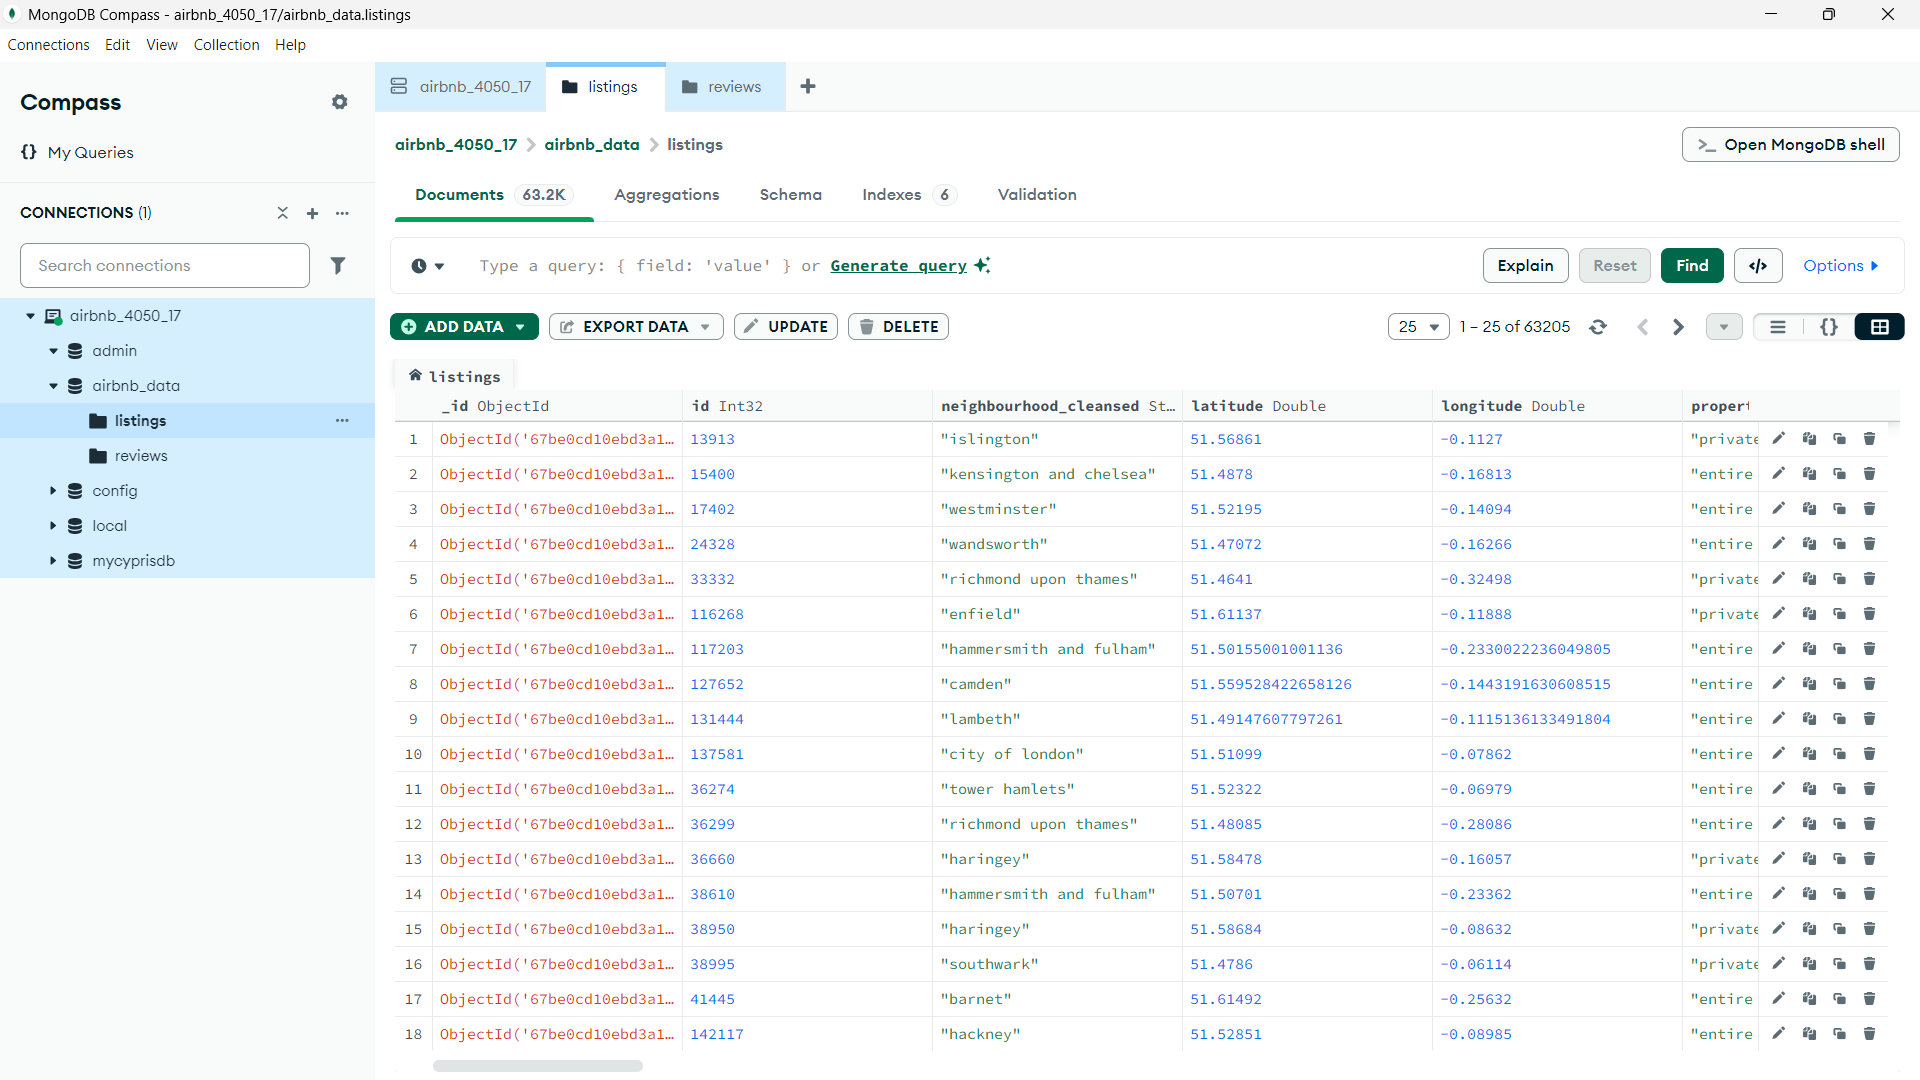

In [41]:
from IPython.display import Image
Image("1.png")

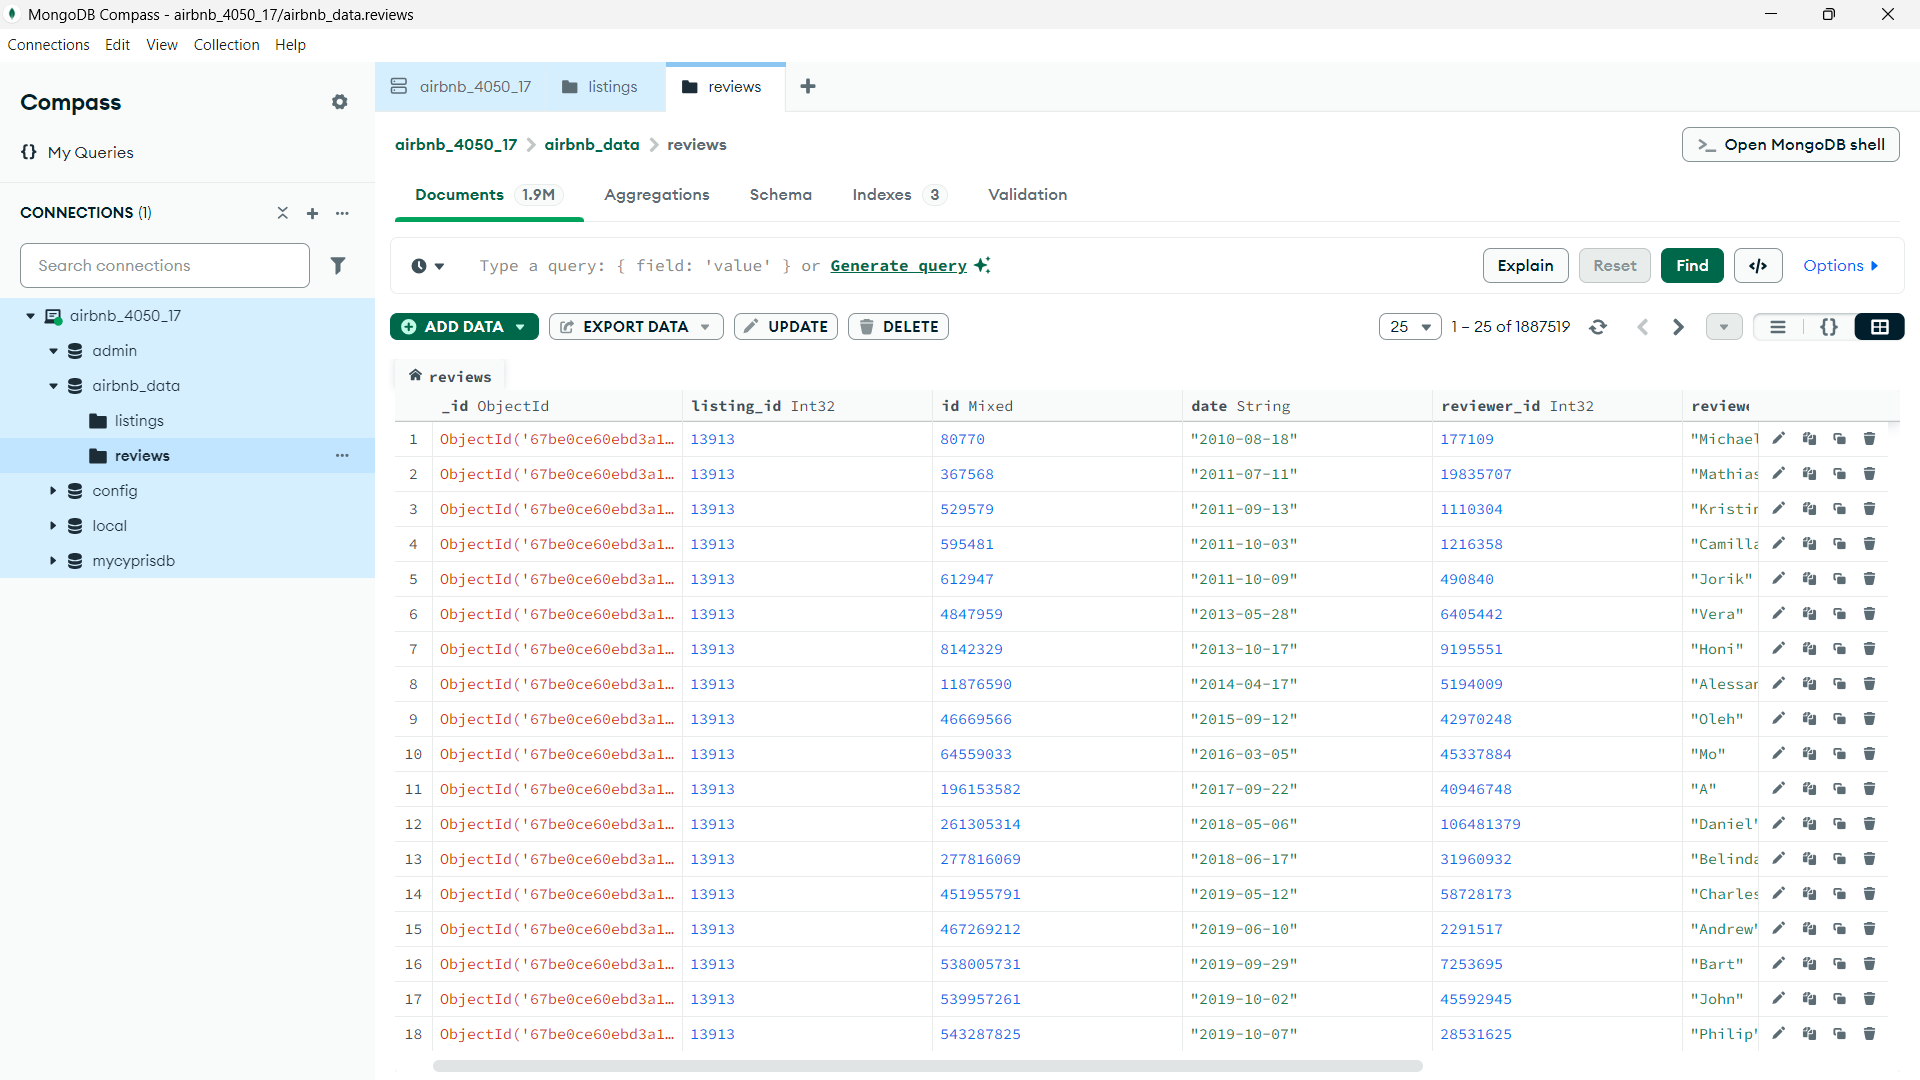

In [42]:
Image("2.png")

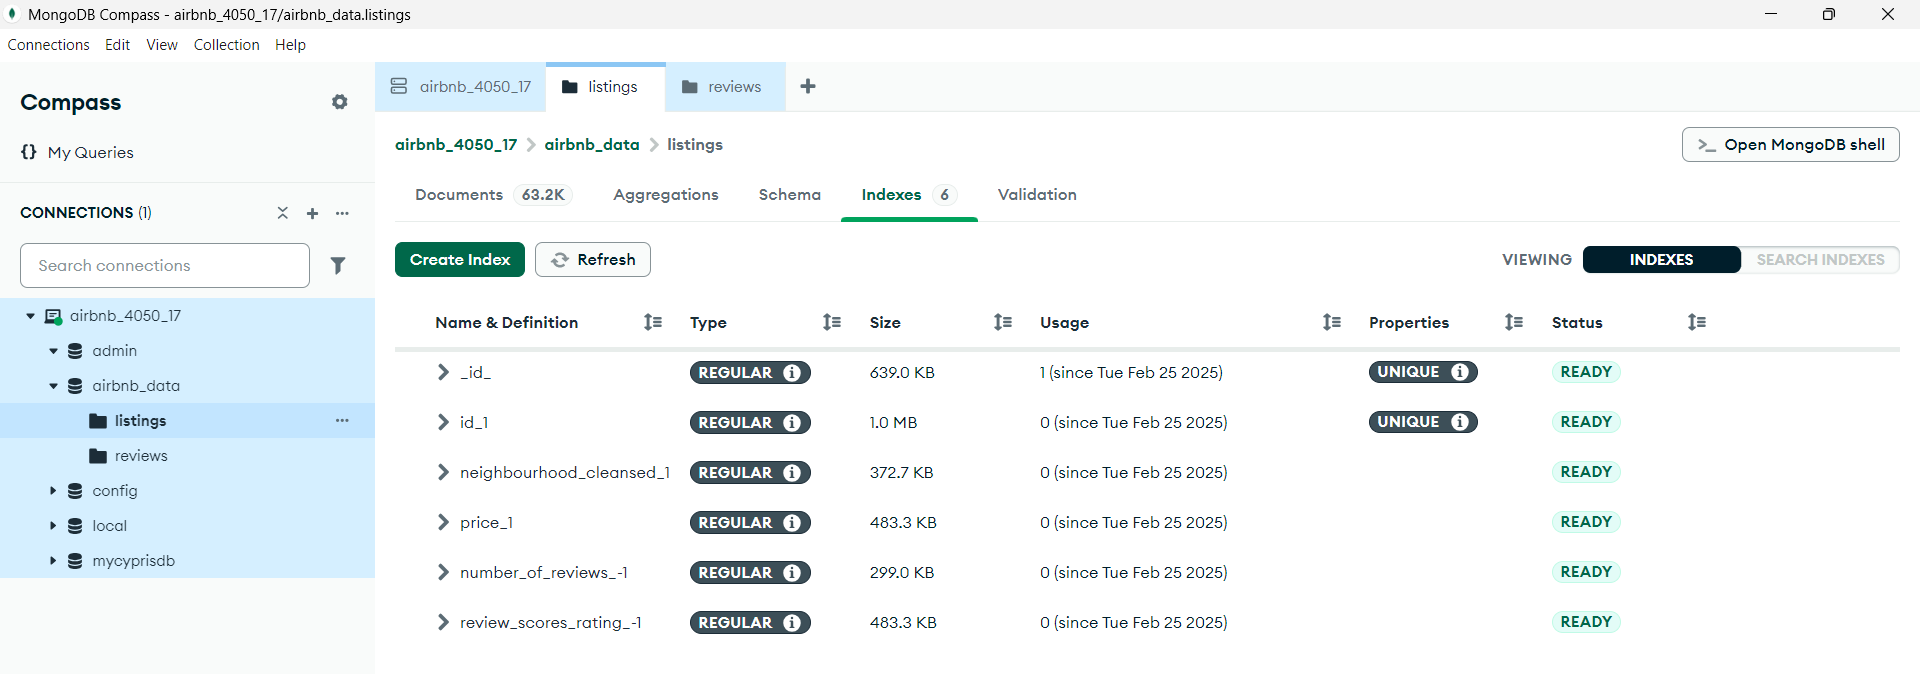

In [45]:
Image("3.png")

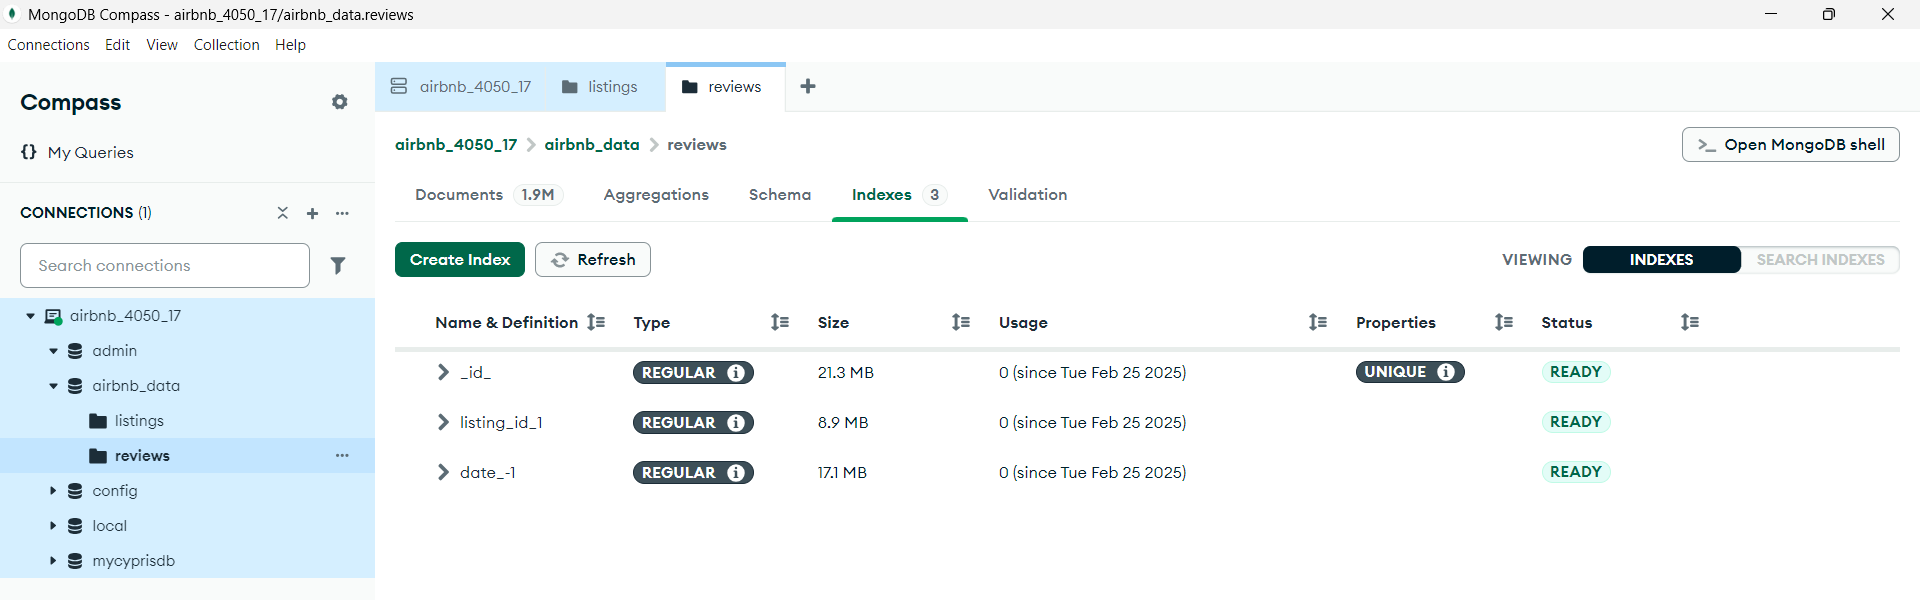

In [46]:
Image("4.png")

**3. Data analysis and taking insights** <br>
a. Neighborhood Profiles  <br>
b. Most Popular Property Types <br>
c. Listings with Highest Reviews <br>
d. Average Ratings Per Property Type <br>
e. Monthly Review Trends <br>

In [9]:
### Step 1: Extract Listings Data
print("Extracting Listings Data...")
listings_cursor = db.listings.find({}, {"_id": 0})  # Exclude MongoDB "_id" field
listings_df = pd.DataFrame(list(listings_cursor))

# Check if data is retrieved
print(f"Retrieved {listings_df.shape[0]} listings.")

### Step 2: Extract Reviews Data
print("Extracting Reviews Data...")
reviews_cursor = db.reviews.find({}, {"_id": 0})
reviews_df = pd.DataFrame(list(reviews_cursor))

# Check if data is retrieved
print(f"Retrieved {reviews_df.shape[0]} reviews.")

### Step 3: Perform Basic Analysis

# Top 5 Most Expensive Neighborhoods
top_neighborhoods = listings_df.groupby("neighbourhood_cleansed")["price"].mean().sort_values(ascending=False).head(5)
print("\n Top 5 Most Expensive Neighborhoods:\n", top_neighborhoods)

# Most Common Property Types
property_counts = listings_df["property_type"].value_counts().head(5)
print("\n Top 5 Most Common Property Types:\n", property_counts)

# Top Rated Listings (Review Score >= 4.8)
top_rated = listings_df[listings_df["review_scores_rating"] >= 4.8][["id", "neighbourhood_cleansed", "price", "review_scores_rating"]].sort_values(by="review_scores_rating", ascending=False)
print("\n Top Rated Listings:\n", top_rated.head(5))

# Average Review Score by Property Type
property_review_scores = listings_df.groupby("property_type")["review_scores_rating"].mean().sort_values(ascending=False)
print("\n Average Review Scores Per Property Type:\n", property_review_scores)

# Monthly Review Trends
reviews_df["date"] = pd.to_datetime(reviews_df["date"])
reviews_df["year_month"] = reviews_df["date"].dt.to_period("M")
monthly_reviews = reviews_df.groupby("year_month").size()

print("\n Monthly Review Trends:\n", monthly_reviews.tail(5))

### Step 4: Save Data for Further Analysis
listings_df.to_csv("listings_mongodb.csv", index=False)
reviews_df.to_csv("reviews_mongodb.csv", index=False)

print("\n Data extracted and saved as CSV files for further analysis.")


Extracting Listings Data...
Retrieved 63205 listings.
Extracting Reviews Data...
Retrieved 1887519 reviews.

 Top 5 Most Expensive Neighborhoods:
 neighbourhood_cleansed
kensington and chelsea    324.943467
westminster               315.281734
lambeth                   274.918117
city of london            268.852732
camden                    215.062673
Name: price, dtype: float64

 Top 5 Most Common Property Types:
 property_type
entire rental unit             26575
private room in home            7810
private room in rental unit     7325
entire condo                    6552
entire home                     5783
Name: count, dtype: int64

 Top Rated Listings:
                        id neighbourhood_cleansed  price  review_scores_rating
27272  809320654844883816              islington  174.0                   5.0
36239  957740141827701878             wandsworth  158.0                   5.0
36144  956331765025258507               haringey  125.0                   5.0
36130  9553227228261

In [10]:
pip install pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


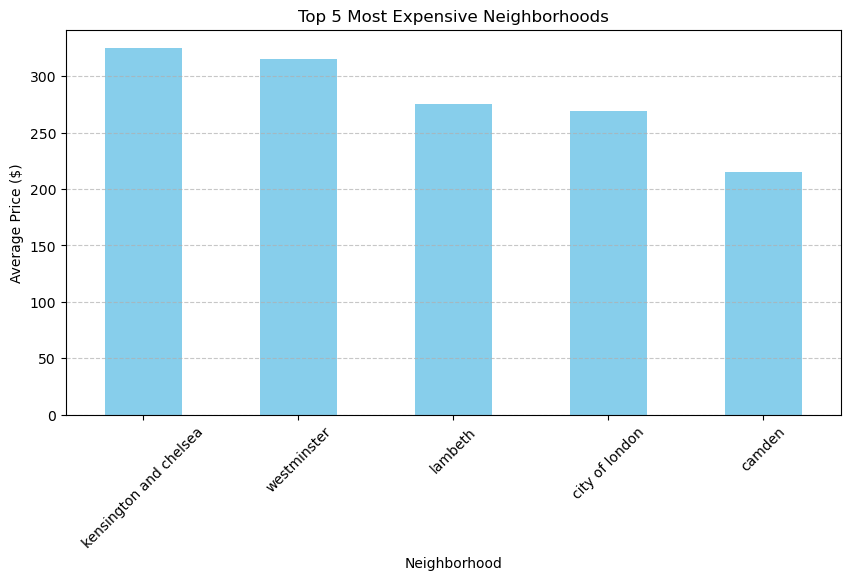

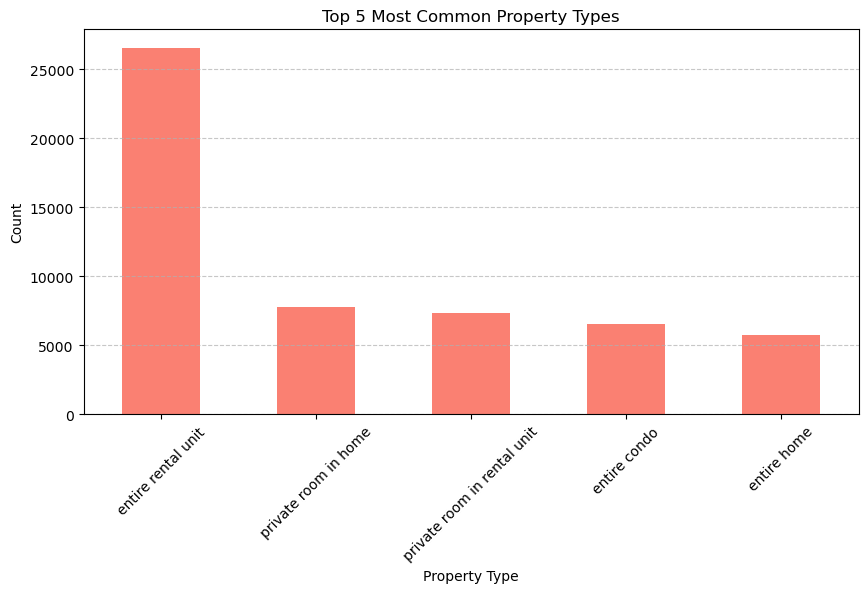

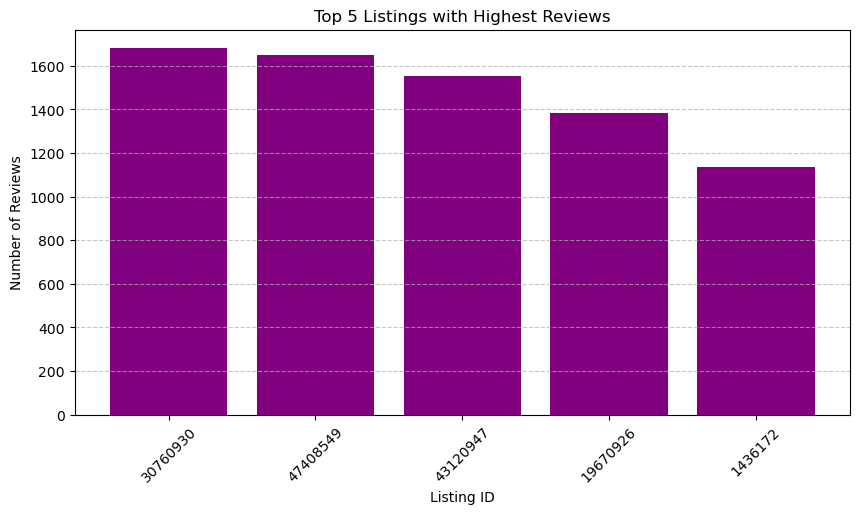

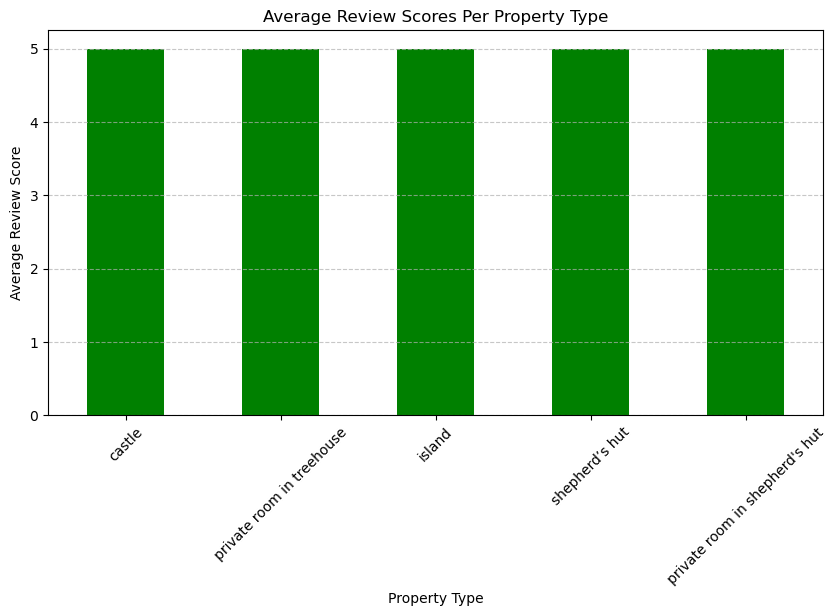

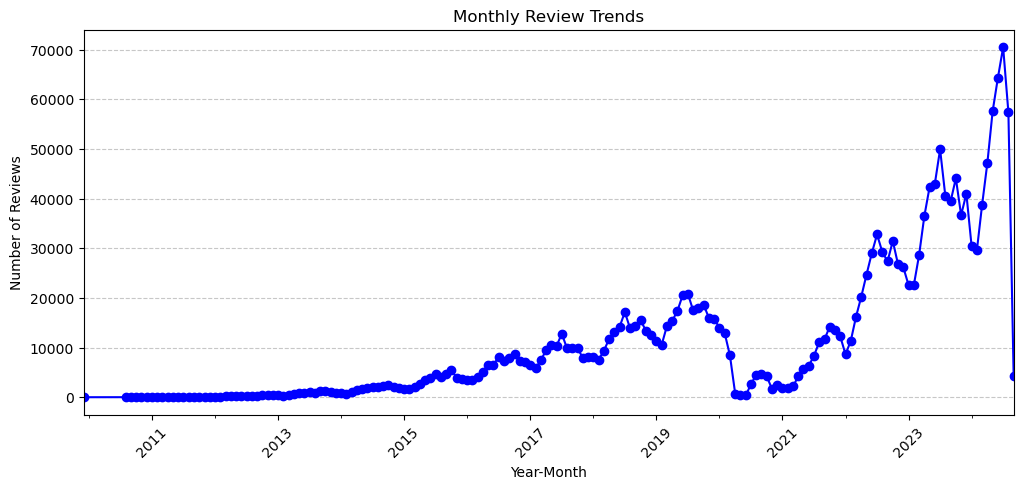

In [14]:
import matplotlib.pyplot as plt

listings_file = "listings_mongodb.csv"
reviews_file = "reviews_mongodb.csv"

# Load the extracted data from MongoDB
listings_df = pd.read_csv(listings_file)
reviews_df = pd.read_csv(reviews_file)

# Convert date column in reviews for time-series analysis
reviews_df["date"] = pd.to_datetime(reviews_df["date"])
reviews_df["year_month"] = reviews_df["date"].dt.to_period("M")

# Visualization 1: Top 5 Most Expensive Neighborhoods
top_neighborhoods = listings_df.groupby("neighbourhood_cleansed")["price"].mean().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 5))
top_neighborhoods.plot(kind="bar", color="skyblue")
plt.title("Top 5 Most Expensive Neighborhoods")
plt.xlabel("Neighborhood")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Visualization 2: Top 5 Most Common Property Types
top_property_types = listings_df["property_type"].value_counts().head(5)
plt.figure(figsize=(10, 5))
top_property_types.plot(kind="bar", color="salmon")
plt.title("Top 5 Most Common Property Types")
plt.xlabel("Property Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Visualization 3: Listings with Highest Reviews
top_reviewed_listings = listings_df.sort_values(by="number_of_reviews", ascending=False).head(5)
plt.figure(figsize=(10, 5))
plt.bar(top_reviewed_listings["id"].astype(str), top_reviewed_listings["number_of_reviews"], color="purple")
plt.title("Top 5 Listings with Highest Reviews")
plt.xlabel("Listing ID")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Visualization 4: Average Ratings Per Property Type
avg_ratings_per_property = listings_df.groupby("property_type")["review_scores_rating"].mean().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 5))
avg_ratings_per_property.plot(kind="bar", color="green")
plt.title("Average Review Scores Per Property Type")
plt.xlabel("Property Type")
plt.ylabel("Average Review Score")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Visualization 5: Monthly Review Trends
monthly_reviews = reviews_df.groupby("year_month").size()
plt.figure(figsize=(12, 5))
monthly_reviews.plot(kind="line", marker="o", color="blue", linestyle="-")
plt.title("Monthly Review Trends")
plt.xlabel("Year-Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

3a. Neighborhood Profiles - Deeper Analysis

Deep Dive: Top 10 Expensive Neighborhoods & Their Review Quality:
                          avg_price  avg_review_score  total_listings  \
neighbourhood_cleansed                                                 
Kensington and Chelsea  324.943467          4.653859            4776   
Westminster             315.281734          4.612779            8075   
Lambeth                 274.918117          4.723119            3102   
City of London          268.852732          4.570841             421   
Camden                  215.062673          4.626479            4324   
Southwark               201.279156          4.687606            3224   
Hammersmith and Fulham  192.574276          4.676810            2659   
Richmond upon Thames    190.634146          4.783942             861   
Wandsworth              184.268560          4.746422            3098   
Islington               182.398814          4.675751            2866   

                        price_per_review  
neighbourhood_cleansed   

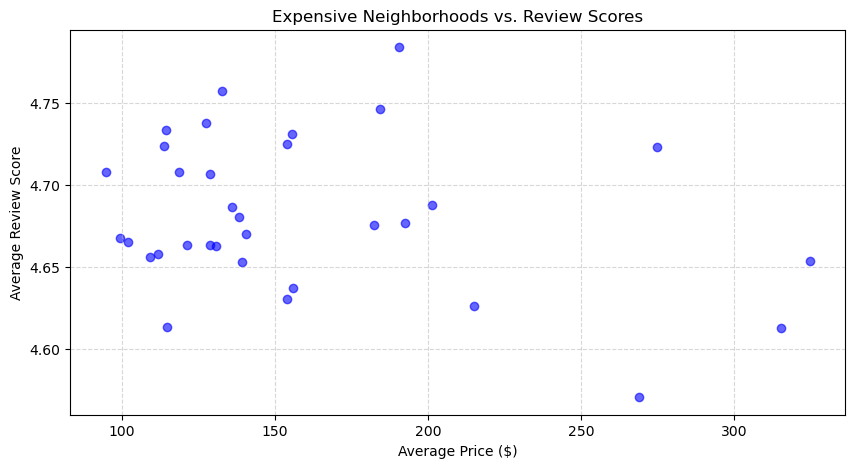

In [48]:
# Calculate multiple metrics per neighborhood
neighborhood_analysis = listings_df.groupby("neighbourhood_cleansed").agg(
    avg_price=("price", "mean"),
    avg_review_score=("review_scores_rating", "mean"),
    total_listings=("id", "count"),
).sort_values(by="avg_price", ascending=False)

# Normalize price and review scores for better comparison
neighborhood_analysis["price_per_review"] = neighborhood_analysis["avg_price"] / neighborhood_analysis["avg_review_score"]

# Display top 10 expensive neighborhoods with their review quality
print("Deep Dive: Top 10 Expensive Neighborhoods & Their Review Quality:\n", neighborhood_analysis.head(10))

# Visualization 1: Expensive Neighborhoods vs. Review Scores (Scatter Plot)
neighborhood_analysis = listings_df.groupby("neighbourhood_cleansed").agg(
    avg_price=("price", "mean"),
    avg_review_score=("review_scores_rating", "mean"),
    total_listings=("id", "count")
).sort_values(by="avg_price", ascending=False)

plt.figure(figsize=(10, 5))
plt.scatter(neighborhood_analysis["avg_price"], neighborhood_analysis["avg_review_score"], color="blue", alpha=0.6)
plt.title("Expensive Neighborhoods vs. Review Scores")
plt.xlabel("Average Price ($)")
plt.ylabel("Average Review Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

```
Neighborhood Profiles: Most Expensive & Best Rated Insights

Expensive neighborhood with high ratings:
    Kensington and Chelsea - 324.94/night (4.65 average review score)
    Westminster - $315.28/night (4.61 average review score)
    Lambeth - 274.91/night (4.72 average review score)
    City of London - $268.85/night (4.57 average review score)
    Camden - $215.06/night (4.62 average review score)

Affordable neighborhood with high ratings:
    Richmond upon Thames - $190.63/night (4.78 review score)
    Waltham Forest - $114.42/night (4.73 review score)
    Haringey - $127.27/night (4.73 review score)


3b. Most Popular Property Types - Deeper Analysis

Deep Dive: Top 10 Most Common Property Types & Their Metrics:
                               avg_price  avg_review_score  total_listings
property_type                                                            
Entire rental unit           218.471308          4.637004           26575
Private room in home          71.245070          4.710149            7810
Private room in rental unit  158.835904          4.677001            7325
Entire condo                 205.794872          4.719063            6552
Entire home                  332.819298          4.702971            5783
Private room in condo         80.902286          4.763753            2712
Entire serviced apartment    272.717085          4.568914            1633
Private room in townhouse     84.266667          4.785044             840
Entire townhouse             510.023077          4.803935             650
Room in hotel                181.369004          4.462104             542


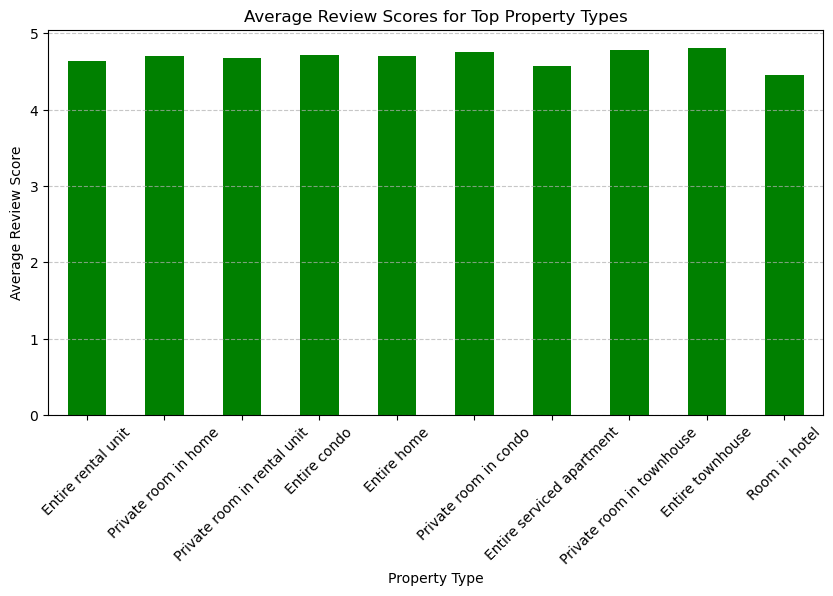

In [49]:
# Analyze price and review scores by property type
property_type_analysis = listings_df.groupby("property_type").agg(
    avg_price=("price", "mean"),
    avg_review_score=("review_scores_rating", "mean"),
    total_listings=("id", "count"),
).sort_values(by="total_listings", ascending=False)

# Display top 10 property types with key metrics
print("Deep Dive: Top 10 Most Common Property Types & Their Metrics:\n", property_type_analysis.head(10))

# Visualization 2: Most Common Property Types vs. Review Scores (Bar Chart)
property_type_analysis = listings_df.groupby("property_type").agg(
    avg_price=("price", "mean"),
    avg_review_score=("review_scores_rating", "mean"),
    total_listings=("id", "count")
).sort_values(by="total_listings", ascending=False).head(10)

plt.figure(figsize=(10, 5))
property_type_analysis["avg_review_score"].plot(kind="bar", color="green")
plt.title("Average Review Scores for Top Property Types")
plt.xlabel("Property Type")
plt.ylabel("Average Review Score")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

```
Most Popular Property Types

The most common property types by listings:
    Entire Rental Unit - 26,575 listings ($218 avg price, 4.63 rating)
    Private Room in Home - 7,810 listings ($71 avg price, 4.71 rating)
    Private Room in Rental Unit - 7,325 listings ($158 avg price, 4.67 rating)
    Entire Condo - 6,552 listings ($205 avg price, 4.71 rating)
    Entire Home - 5,783 listings ($332 avg price, 4.70 rating)

Some less common properties have better review scores:
    Entire Cottage - $181 avg price, 4.81 rating
    Shared Room in Guesthouse - $49 avg price, 4.88 rating
    Private Room in Cottage - $79 avg price, 4.86 rating


3c. Listings with Highest Reviews - Deeper Analysis

Deep Dive: Top 10 Listings with Highest Reviews:
              id neighbourhood_cleansed                      property_type  \
9522   30760930            westminster             room in boutique hotel   
15010  47408549                 camden                      room in hotel   
13685  43120947                hackney                      room in hotel   
6002   19670926          tower hamlets          entire serviced apartment   
830     1436172                 camden          private room in townhouse   
14179  45006692            westminster  private room in bed and breakfast   
1069    2126708              islington        private room in rental unit   
831     1436177                 camden          private room in townhouse   
1518    3855375                 camden               private room in home   
1171    2659707          tower hamlets        private room in rental unit   

       price  number_of_reviews  review_scores_rating  \
9522   204.0               1682              

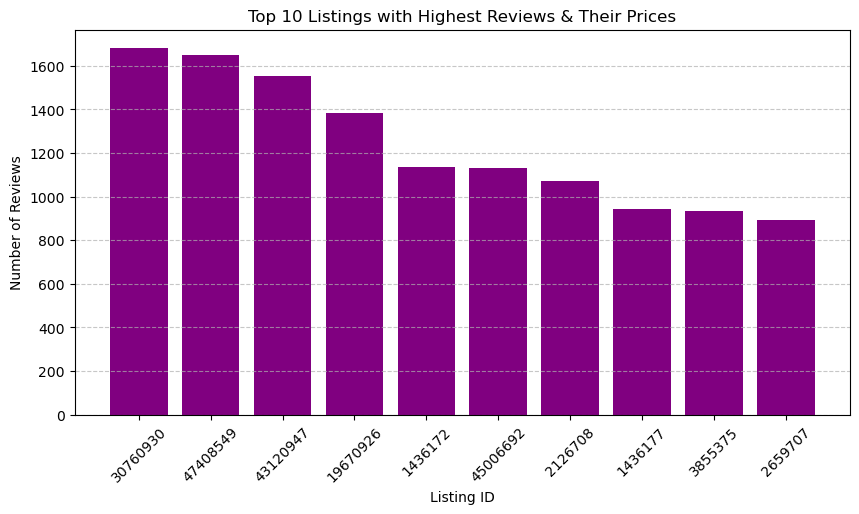

In [23]:
# Find top reviewed listings and analyze key factors
top_reviewed_listings = listings_df.sort_values(by="number_of_reviews", ascending=False).head(10)

# Show selected columns for insights
print("Deep Dive: Top 10 Listings with Highest Reviews:\n", 
      top_reviewed_listings[["id", "neighbourhood_cleansed", "property_type", 
                             "price", "number_of_reviews", "review_scores_rating", "amenities"]])

# Visualization 3: Listings with Most Reviews & Their Price (Bar Chart)
top_reviewed_listings = listings_df.sort_values(by="number_of_reviews", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(top_reviewed_listings["id"].astype(str), top_reviewed_listings["number_of_reviews"], color="purple")
plt.title("Top 10 Listings with Highest Reviews & Their Prices")
plt.xlabel("Listing ID")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

```
Listings with Highest Reviews

The top 5 most reviewed listings are:
    Westminster - Room in Boutique Hotel (1682 reviews, $204/night, 4.55 rating)
    Camden - Room in Hotel (1650 reviews, $127/night, 4.43 rating)
    Hackney - Room in Hotel (1553 reviews, $114/night, 4.48 rating)
    Tower Hamlets - Entire Serviced Apartment (1382 reviews, $266/night, 4.79 rating)
    Camden - Private Room in Townhouse (1134 reviews, $98/night, 4.62 rating)

Top-reviewed listings tend to have specific amenities:
    Fast WiFi
    Self-check-in
    Workspace
    Refrigerator & Kitchen
    Iron & Laundry Facilities


3d. Average Ratings Per Property Type - Deeper Analysis

Correlation between Price & Review Scores:
                   avg_price  avg_review_score
avg_price          1.000000          0.073131
avg_review_score   0.073131          1.000000

Property Types with High Reviews & Affordable Prices:
                                  avg_price  avg_review_score
property_type                                               
castle                          147.000000          5.000000
private room in treehouse        90.000000          5.000000
island                          219.000000          5.000000
shepherd’s hut                  289.666667          4.996667
private room in shepherd's hut  229.000000          4.990000
earthen home                    129.000000          4.905000
private room in houseboat       153.500000          4.895000
shared room in guesthouse        49.200000          4.884386
private room in cottage          79.736842          4.863158
shipping container               45.000000          4.860000


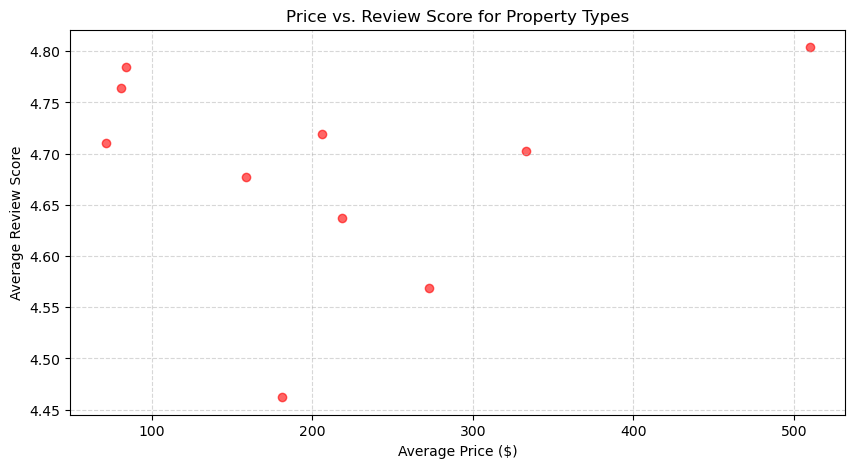

In [24]:
# Compute correlation between price and rating per property type
property_review_correlation = listings_df.groupby("property_type").agg(
    avg_price=("price", "mean"),
    avg_review_score=("review_scores_rating", "mean"),
).corr()

print("Correlation between Price & Review Scores:\n", property_review_correlation)

# Display property types with high review scores despite lower prices
best_value_properties = listings_df.groupby("property_type").agg(
    avg_price=("price", "mean"),
    avg_review_score=("review_scores_rating", "mean"),
).sort_values(by="avg_review_score", ascending=False)

print("\nProperty Types with High Reviews & Affordable Prices:\n", best_value_properties.head(10))

# Visualization 4: Price vs. Review Score for Property Types (Scatter Plot)
plt.figure(figsize=(10, 5))
plt.scatter(property_type_analysis["avg_price"], property_type_analysis["avg_review_score"], color="red", alpha=0.6)
plt.title("Price vs. Review Score for Property Types")
plt.xlabel("Average Price ($)")
plt.ylabel("Average Review Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

```
Average Ratings Per Property Type

Property types with the best review scores: 
    Entire Cottage - 4.81 rating
    Private Room in Cottage - 4.86 rating
    Shared Room in Guesthouse - 4.88 rating
    Entire Villa - 4.77 rating
    Houseboat - 4.80 rating

Property types with lower ratings: 
    Room in Serviced Apartment - 4.34 rating
    Shared Room in Hotel - 4.26 rating
    Private Room in Hostel - 4.15 rating
    Barn - 4.03 rating
    Entire Chalet - 2.94 rating (worst rating)

3e. Monthly Review Trends - Deeper Analysis


 Deep Dive: Monthly Review Trends (Last 12 Months):
             total_reviews   rolling_avg
year_month                             
2023-10             44076  41324.666667
2023-11             36664  40049.000000
2023-12             40976  40572.000000
2024-01             30384  36008.000000
2024-02             29567  33642.333333
2024-03             38774  32908.333333
2024-04             47198  38513.000000
2024-05             57573  47848.333333
2024-06             64296  56355.666667
2024-07             70467  64112.000000
2024-08             57343  64035.333333
2024-09              4256  44022.000000


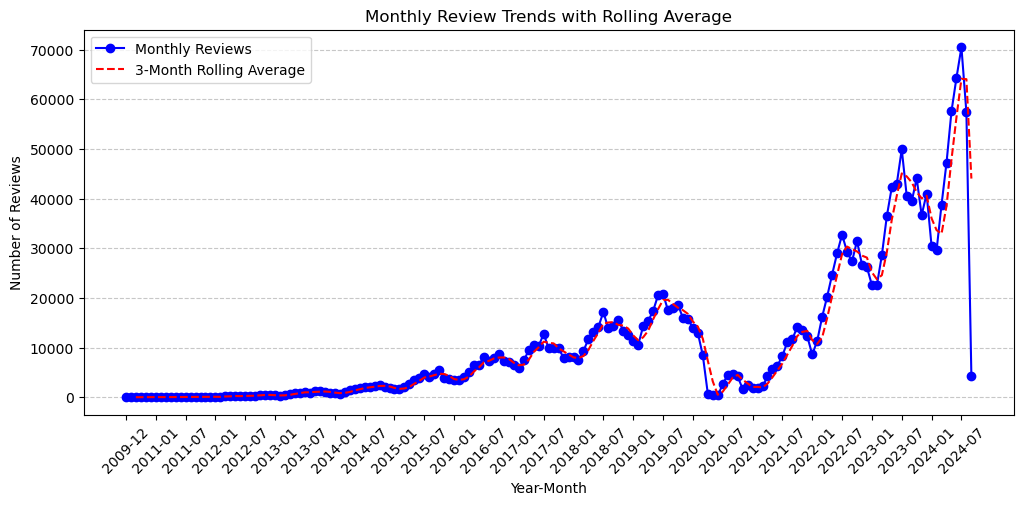

In [28]:
# Compute rolling average of reviews for smoother trend
reviews_df["review_count"] = 1  # Create a count column
monthly_review_trends = reviews_df.groupby("year_month").agg(total_reviews=("review_count", "sum"))
monthly_review_trends["rolling_avg"] = monthly_review_trends["total_reviews"].rolling(3).mean()

# Display last 12 months' trends
print("\n Deep Dive: Monthly Review Trends (Last 12 Months):\n", monthly_review_trends.tail(12))

# Visualization 5: Monthly Review Trends with Rolling Average (Line Chart)
monthly_review_trends = reviews_df.groupby("year_month").size()
rolling_avg = monthly_review_trends.rolling(3).mean()

plt.figure(figsize=(12, 5))
plt.plot(monthly_review_trends.index.astype(str), monthly_review_trends, marker="o", linestyle="-", color="blue", label="Monthly Reviews")
plt.plot(monthly_review_trends.index.astype(str), rolling_avg, linestyle="--", color="red", label="3-Month Rolling Average")
plt.title("Monthly Review Trends with Rolling Average")
plt.xlabel("Year-Month")
plt.ylabel("Number of Reviews")
plt.xticks(monthly_review_trends.index[::6].astype(str), rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

```
Monthly Review Trends

Peak travel seasons (highest number of reviews): 
    July - August (Summer)
    May - June (Spring)

Slow travel seasons (lowest number of reviews):
    January - February (Winter)
    March - April (Early Spring)

COVID-19 impact: 
    April 2020 - Sharp drop in reviews due to travel restrictions.
    July 2021 - Present - Strong recovery and continued growth.


## Conclusion:

   **Neighborhood Profiles** <br>
    Takeaway Message: Expensive areas don’t always have the best reviews. <br>	
    Recommendation: Improve service in high-priced areas or adjust pricing. <br>

   **Most Popular Property Types** <br>
    T: Some unique property types (cottages, guesthouses) have the best reviews.<br>	
    R: Hosts should offer unique stays for higher ratings. <br>

   **Listings with Highest Reviews** <br>	
    T: Listings with WiFi, workspace, and self-check-in tend to get more reviews. <br>	
    R: Add guest-friendly amenities to boost ratings. <br>
    
   **Average Ratings vs. Property Type** <br>
    T: Some cheaper property types have better reviews than luxury ones. <br>	
    R: Luxury stays should focus on service quality. <br>

   **Monthly Review Trends** <br>
    T: Demand peaks during summer; winter bookings drop. <br>	
    R: Increase prices in peak seasons, offer discounts in off-seasons.


                                  ***